# Bond Dimension Required vs. Number of Nodes

In [41]:
include("../funcs/adjacency.jl")  
include("../funcs/mps.jl")  
include("../funcs/hamiltonian.jl")
include("../funcs/json.jl")

write_data_as_json (generic function with 1 method)

## Params

In [11]:
num_graphs_to_avg = 10 # number of graphs to average over for each (N, σ) pair
N_vals = 10:2:100 # number of nodes to test
σ_vals = [0.0, 0.001, 0.002] # sigma values to test for the adjacency martrix

J = 1.0 # interaction strength
Δ = 1.5 # anisotropy parameter




1.5

# Generate MPOs

In [29]:
using JSON

data = Dict{Float64, Dict{Int, Tuple{Float64, Float64}}}()

if isfile("../data/bond_dim_vs_nodes_data.json")
    open("../data/bond_dim_vs_nodes_data.json", "r") do f
        loaded_data = JSON.parse(f)
        
        # Convert string keys back to proper types
        for (σ_str, σ_data) in loaded_data
            σ = parse(Float64, σ_str)  # Convert string key to Float64
            data[σ] = Dict{Int, Tuple{Float64, Float64}}()
            
            for (N_str, values) in σ_data
                N = parse(Int, N_str)  # Convert string key to Int
                # Values might be arrays, convert to tuple
                if isa(values, Array)
                    data[σ][N] = (values[1], values[2])
                else
                    data[σ][N] = values
                end
            end
        end
    end
end

In [13]:
using ITensorMPS, ITensors
using ProgressMeter
import Statistics

if !data:
    data = Dict() # {σ => {N => (max_bond_dim, error)}}

    total_iterations = length(N_vals) * length(σ_vals)
    progress = Progress(total_iterations, desc="Calculating bond dimensions")

    for N in N_vals
        for σ in σ_vals
            local_averaging = σ != 0.0 ? num_graphs_to_avg : 1 # only bother averaging if we actually have randomness

            bond_dims = Int[]
            for _ in 1:local_averaging
                wam = generate_fully_connected_wam(N, σ) # weighted adjacency matrix
                ψ_mps, sites = create_MPS(N)
                H = create_xxz_hamiltonian_mpo(N, wam, J, Δ, sites)
                max_bond_dim = maxlinkdim(H) # maximum bond dimension of the MPO hamiltonian
                push!(bond_dims, max_bond_dim)
            end

            avg_bond_dim = Statistics.mean(bond_dims) # average over local_averaging graphs
            error = σ != 0.0 ? Statistics.std(bond_dims) : 0 # standard deviation if we have randomness, else 0

            # create the sigma key if it doesn't exist
            if !haskey(data, σ)
                data[σ] = Dict()
            end
            data[σ][N] = (avg_bond_dim, error)

            next!(progress)
        end
    end

Calculating bond dimensions 100%|████████████████████████| Time: 0:22:43


In [ ]:
# save the data in json format
write_data_as_json("../data/bond_dim_vs_nodes_data.json", data)

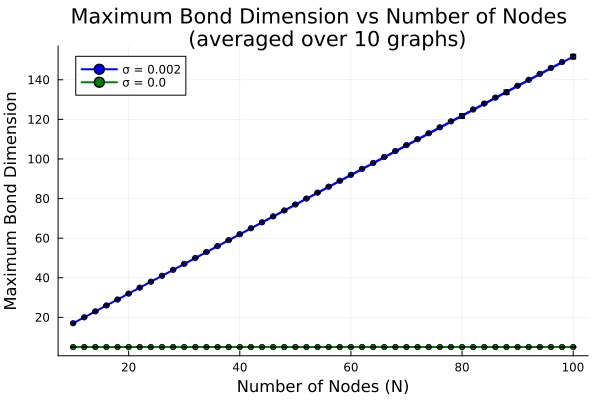

In [38]:
# plot the data using plots
using Plots

σ_to_plot = [0.0, 0.002]

# we should have all the sigma values on the same plot, we want avg_bond_dim vs N with error bars
colors = [:red, :blue, :green, :orange, :purple]
plt = plot(title="Maximum Bond Dimension vs Number of Nodes \n (averaged over $num_graphs_to_avg graphs)",
    xlabel="Number of Nodes (N)",
    ylabel="Maximum Bond Dimension",
    legend=:topleft)

for (i, σ) in enumerate(keys(data))
    if !(σ in σ_to_plot)
        continue
    end
    σ_data = data[σ]
    N_vals = collect(keys(σ_data))
    avg_bond_dims = [σ_data[N][1] for N in N_vals]
    errors = [σ_data[N][2] for N in N_vals]

    plot!(plt, N_vals, avg_bond_dims, 
          yerror=errors,
          label="σ = $σ", 
          color=colors[i % length(colors) + 1],
          marker=:circle,
          markersize=3,
          linewidth=2)
end
savefig(plt, "../assets/graphs/bond_dim_req_vs_nodes_ham_mpo.png")
display(plt)

# Same thing, but for Ground State MPS at sigma=0.0